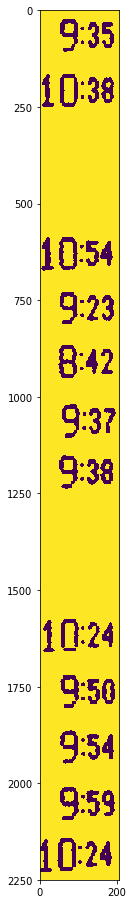

['9:35', '10:38', '', '10:54', '9:23', '8:42', '9:37', '9:38', '', '10:24', '9:50', '9:54', '9:59', '', '10:24']


In [2]:
import pytesseract
from pdf2image import convert_from_bytes,convert_from_path
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import re
from PIL import Image

def remove_grid(img,line_dim=(1,100)):
    kernel_h = np.ones(line_dim, np.uint8)  
    lines_h = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_h)

    kernel_v = np.ones(line_dim[::-1], np.uint8)  
    lines_v = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_v)

    img = cv2.add(img, (255-lines_h))
    img = cv2.add(img, (255-lines_v))
    
    return img

def alignImages(im1, im2):  
    '''Source: https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/'''
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.30
 
    # Convert images to grayscale
    #im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    #im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im1Gray = im1
    im2Gray = im2
     
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
     
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
     
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
 
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)
     
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
     
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
     
    return im1Reg, h

def smooth_binary(img):
    
    n_kernel=5
    param_gauss_1 = (7,7)
    param_gauss_2 = 3
    img = cv2.GaussianBlur(img,param_gauss_1,param_gauss_2)
    #img = cv2.medianBlur(img,3)
    
    kernel = np.ones((n_kernel,n_kernel),np.float32)/(n_kernel*n_kernel)
    img = cv2.filter2D(img,-1,kernel)
    _,img = cv2.threshold(img,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return img

def read_pdf_as_img(pdf_file,page=0,dpi=600):
    pdf = convert_from_path(pdf_file,dpi=dpi)
    return np.array(pdf[page].convert('L'))

img_ref = read_pdf_as_img('SKM10518091013230.pdf')
img = read_pdf_as_img('SKM10518091013231.pdf')

#img_ref = cv2.imread('0y70V.png',cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('OSb9V.png',cv2.IMREAD_GRAYSCALE)

#himg, h = alignImages(img,img_ref)



y,dy = 1620, 2250

x = 220
dx = 205
col_a = img[y:y+dy,x:x+dx]

x = 1060
dx = 205
col_b = img[y:y+dy,x:x+dx]

col_a = remove_grid(col_a)
col_a = smooth_binary(col_a)

col_b = remove_grid(col_b)
col_b = smooth_binary(col_b)

plt.figure(figsize = (8,16))
plt.imshow(col_a)
plt.show()

def ocr(img):
    whitelist= ':0123456789'
    config = '--psm 1 --oem 0 -c tessedit_char_whitelist=%s '%(whitelist)
    ocr = pytesseract.image_to_string(img,lang="eng",config=config)
    return ocr


print(ocr(col_a).split('\n'))

In [3]:
import pandas as pd


df = pd.DataFrame.from_dict({'kommt':ocr(col_a).split('\n'),'geht':ocr(col_b).split('\n')},orient='index')
df = df.transpose()

df['kommt_h'] = df['kommt'].str.split(':', expand=True)[0]
df['kommt_min'] = df['kommt'].str.split(':', expand=True)[1]
df['geht_h'] = df['geht'].str.split(':', expand=True)[0]
df['geht_min'] = df['geht'].str.split(':', expand=True)[1]
df = df.drop(columns=['kommt','geht'])
df

,kommt_h,kommt_min,geht_h,geht_min
0,9,35,17,33
1,10,38,17,41
2,,None,,None
3,10,54,16,41
4,9,23,16,23
5,8,42,14,59
6,9,37,16,29
7,9,38,16,36
8,,None,,None
9,10,24,17,17
